In [2]:
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt

import IPython.display as ipd

import numpy as np
import torch

from hparams import create_hparams
from model import SpeakerEncoder
from audio import init_stft, mel_spectrogram

import warnings
warnings.filterwarnings("ignore")


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



/Users/olehmatsuk/opt/anaconda3/envs/taco/lib/python3.6/site-packages/librosa/util/decorators.py:9: NumbaDeprecationWarning: An import was requested from a module that has moved location.
Import of 'jit' requested from: 'numba.decorators', please update to use 'numba.core.decorators' or pin to Numba version 0.48.0. This alias will not be present in Numba version 0.50.0.
  from numba.decorators import jit as optional_jit


In [3]:
checkpoint_path = '/Users/olehmatsuk/Thesis/runs/speaker2_May20_12_37_25/checkpoint_40600'

In [4]:
hparams = create_hparams()
stft = init_stft(hparams)

In [5]:
model = SpeakerEncoder(hparams)
if checkpoint_path is not None: 
    model.load_state_dict(torch.load(checkpoint_path, map_location=torch.device('cpu'))['state_dict'])

In [13]:
import pandas as pd

test = pd.read_csv('/Users/olehmatsuk/Thesis/data_files/konekorpus/test.csv')
test = test.sample(100)
test.head()

,text,mel,mel_len,speaker
965,Alustada tuli puhtalt lehelt ehk Itaalia tugev...,../data/mels/konekorpus/Robert_0001_art_941_la...,423,9
2794,Ohvrite ja purustuste kohta teated puuduvad.,../data/mels/konekorpus/Tõnu_Karjatse_20051213...,183,5
727,"Beitostölenis võitis Röthe, venelastel uus mee...",../data/mels/konekorpus/Robert_0001_art_1146_l...,301,9
4456,Samuti annab Trumpi hinnangul USAle suure eeli...,../data/mels/konekorpus/Robert_0001_art_693_la...,621,9
3239,"Sel hooajal osaleb kuus rahvuskoondist, A-grup...",../data/mels/konekorpus/Katarina_0001_art_1194...,1135,7


In [14]:
from tqdm import tqdm

speaker_embeddings = []

for _, row in tqdm(list(test.iterrows())):
    mel = torch.from_numpy(np.load(row['mel'])).transpose(0, 1).unsqueeze(0)
    fragments = mel.unfold(1, 36, 18).transpose(2, 3)[0]
    speaker_embedding = model.inference(fragments, [fragments.size(0)])
    speaker_embeddings.append(speaker_embedding)

speaker_embeddings = torch.cat(speaker_embeddings)
speaker_embeddings.size()

100%|██████████| 100/100 [00:30<00:00,  3.25it/s]


torch.Size([100, 256])

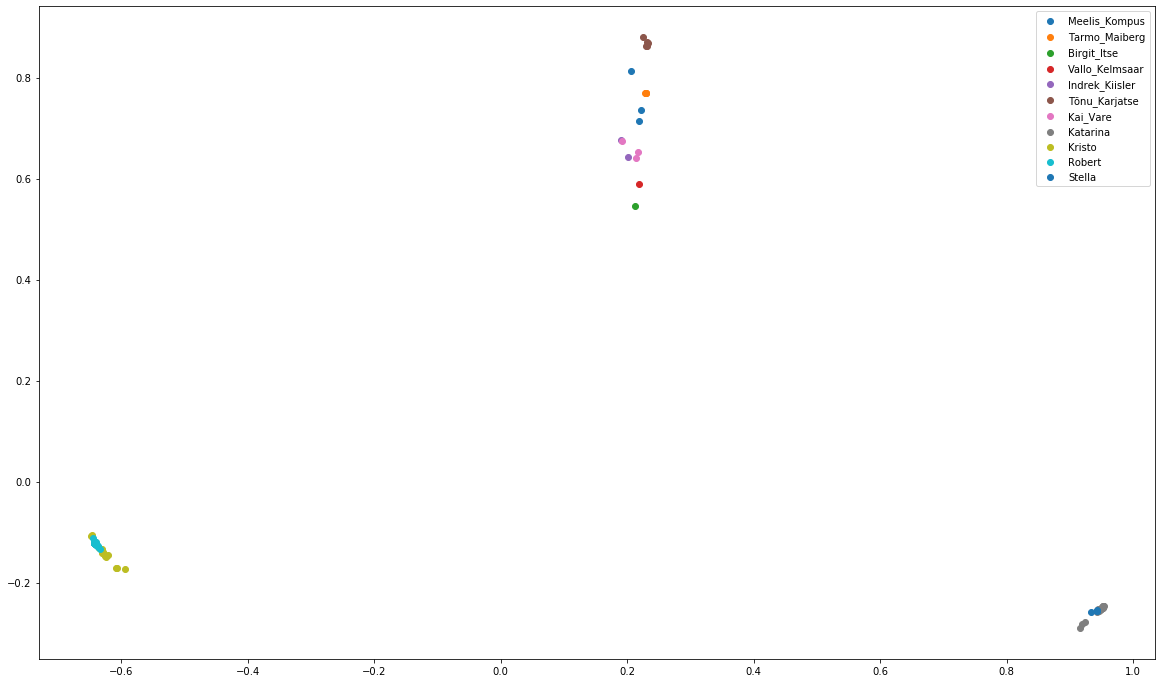

In [18]:
from sklearn.decomposition import PCA



speakers = ["Meelis_Kompus", "Tarmo_Maiberg", "Birgit_Itse", "Vallo_Kelmsaar", "Indrek_Kiisler",
            "Tõnu_Karjatse", "Kai_Vare", "Katarina", "Kristo", "Robert", "Stella"]

pca = PCA(n_components=2)
embeddings = pca.fit_transform(speaker_embeddings.detach().numpy())
labels = test['speaker'].values


plt.figure(figsize=(20, 12))
for label in np.unique(labels):
    label_index = labels == label
    plt.scatter(embeddings[label_index, 0], embeddings[label_index, 1], label=speakers[label])

plt.legend()